In [11]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'hate-speech-and-offensive-language-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F723100%2F1257215%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240426%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240426T164901Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0bb5ffedcdbf7f27605940fd1ee8ef344bc174a449ab31cfe9edbe8db934b120f52b40cd2435285ece61cc820d34f9f8af24401e0109c3fd87c1a9982b57ed050f9407e938f2c0311f66826038e59ce098ace4b6ffcd079e98010c0deff281b863034f58b65c10949f47b08d3f56cd4fa6f04aee2bce05808670a366f0bb4d40b64a26038caa74ff355a58386a3175d2c1fb096457cfe894fba88f2bc57650e4fa66a8c75c430266e1e85c8fda72ea0a2024a5269b4e44c718ef76828c53d1ee99f6440e25729a42fe2fbaa927f773caaf0099395747f2e1609400fe69acf440b9120b5fa49297465530391a65b450fd8b40f42df9bae13fbfa8fd380c9bf568'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1055041 bytes downloaded
Downloaded and uncompressed: hate-speech-and-offensive-language-dataset
Data source import complete.


In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hate-speech-and-offensive-language-dataset/labeled_data.csv


## Preface
The majority of the code in this notebook is taken from <br>
1: [BERT with HuggingFace Transformers, kaggle](https://www.kaggle.com/code/tuckerarrants/bert-with-huggingface-transformers) <br>
2: [BERT Fine-Tuning Tutorial with PyTorch
By Chris McCormick and Nick Ryan, google colab](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP?usp=sharing)

In [13]:
CLEAN_TWEETS = False

# Importing library and checking GPU

In [14]:
import numpy as np
import pandas as pd
import os, re

import matplotlib.pyplot as plt

In [15]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# Check if the device name is empty.
if not device_name:
    print('GPU device not found.')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [16]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [17]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [18]:
#!pip install transformers

Installing Hugging face lib, but look like they already interaged in

In [19]:
import pandas as pd
df = pd.read_csv('/content/labeled_data.csv')

print('Number of training sentences: {:,}\n'.format(df.shape[0]))
# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 24,783



,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
16497,16875,3,0,0,3,2,RT @Mobute: Rick Scott vs. Charlie Crist is th...
10643,10923,3,0,3,0,1,I know you seeeeen my faceeeee gon send a bitc...
19258,19687,3,0,1,2,2,RT @intelwire: Significant number of US tweets...
18053,18457,3,1,2,0,1,"RT @WhenEminemSaid: When Eminem said ""Call me ..."
18129,18534,3,0,3,0,1,RT @YG: I switched up. You fukin with my old b...
7244,7451,3,0,0,3,2,@valerie91097 uhh messi trash . and im flatter...
5467,5625,3,0,3,0,1,@adorianloveee man fuck this bitch http://t.co...
24528,25035,3,0,0,3,2,the trash wheel has a twitter? and googly eyes?
5262,5417,3,0,3,0,1,@ZayySwanson @_EmaniMilan I'm jus Tryn figure ...
23674,24168,3,0,3,0,1,bitches love good morning posts


In the [class] collum: <br>
0 prefer to hate speech <br>
1 is offensive <br>
2 is neither

# Preprocessing

In [20]:
#strip tweet related character
def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
#check functionality
print(df['tweet'][1])
strip_all_entities(df['tweet'][1])

!!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!


'RT boy dats cold tyga dwn bad for cuffin dat hoe in the 1st place'

In [21]:
if CLEAN_TWEETS == False:
    df['tweet']=df['tweet'].apply(strip_all_entities)

In [22]:
sentences = df['tweet'].values
labels = df['class'].values

# Train Test Val split

In [23]:
from sklearn.model_selection import train_test_split

train, Teal = train_test_split(df, random_state=1508, shuffle=True, test_size=0.2)

In [24]:
test, validation = train_test_split(Teal, random_state=1508, shuffle=True, test_size=0.5)

In [25]:
# Get the lists of sentences and their labels.
trn_sentences = train['tweet'].values
train_labels = train['class'].values

tst_sentences = test['tweet'].values
test_labels = test['class'].values

val_sentences = validation['tweet'].values
validation_labels = validation['class'].values

## tokenization

In [26]:
from transformers import BertTokenizer

print('loading Bert tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

loading Bert tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
enc_exp = tokenizer.encode('My name is Quan')
dec_exp = tokenizer.decode(enc_exp)
print(enc_exp)
print(dec_exp)

[101, 2026, 2171, 2003, 24110, 102]
[CLS] my name is quan [SEP]


## padding & masking

In [28]:
print('Max array length: ', max([len(i) for i in sentences]))

Max array length:  581


In [29]:
count1, count2, count3 = 0, 0, 0
for i in sentences:
    if len(i)>100:
        count1+=1
    if len(i)>200:
        count2+=1
    if len(i)>300:
        count3+=1
print('number of array longer than 100: ', count1)
print('number of array longer than 200: ', count2)
print('number of array longer than 300: ', count3)

number of array longer than 100:  5713
number of array longer than 200:  23
number of array longer than 300:  7


In [30]:
# from statistics import mean

# token_len = []
# for i in sentences:
#     if len(i)>100 and len(i)<200:
#         enc = tokenizer.encode(i)
#         token_len.append(len(enc))
# print('average token length: ', mean(token_len))
# print('maximum token length: ', max(token_len))

--output-- <br>
average token length:  31.558446124099138 <br>
maximum token length:  83

In [31]:
# count = 0
# for i in token_len:
#     if i > 64:
#         count+=1
# print('number of sentence longer than 64 words:', count)

--output-- <br>
number of sentence longer than 64 words: 14

In [32]:
def bert_encode(data, max_len) :
    input_ids = []
    attention_masks = []


    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length = max_len,
                                        padding = 'max_length',
                                        truncation = True,
                                        return_attention_mask=True)

        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

In [33]:
print(len(sentences),len(trn_sentences),len(tst_sentences),len(val_sentences))

24783 19826 2478 2479


In [34]:
MAX_LEN = 64
train_inputs, train_masks = bert_encode(trn_sentences,MAX_LEN)

#test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

validation_inputs, validation_masks = bert_encode(val_sentences,MAX_LEN)

## convert data to pytorch datatype

In [35]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [36]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# BERT for sequence classification

In [37]:
from transformers import BertForSequenceClassification, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

## optimizer

In [38]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8) # args.adam_epsilon  - default is 1e-8.

In [39]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## training loop

In [40]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [41]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [42]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)

        # The call to `model` always returns a tuple, so we need to pull the
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:14.
  Batch    80  of    620.    Elapsed: 0:00:27.
  Batch   120  of    620.    Elapsed: 0:00:40.
  Batch   160  of    620.    Elapsed: 0:00:54.
  Batch   200  of    620.    Elapsed: 0:01:08.
  Batch   240  of    620.    Elapsed: 0:01:21.
  Batch   280  of    620.    Elapsed: 0:01:34.
  Batch   320  of    620.    Elapsed: 0:01:48.
  Batch   360  of    620.    Elapsed: 0:02:01.
  Batch   400  of    620.    Elapsed: 0:02:14.
  Batch   440  of    620.    Elapsed: 0:02:28.
  Batch   480  of    620.    Elapsed: 0:02:41.
  Batch   520  of    620.    Elapsed: 0:02:54.
  Batch   560  of    620.    Elapsed: 0:03:08.
  Batch   600  of    620.    Elapsed: 0:03:21.

  Average training loss: 0.31
  Training epcoh took: 0:03:28

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:09

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    620.    Elapsed: 0:00:13.
  Batch    80  of    620.    Elap

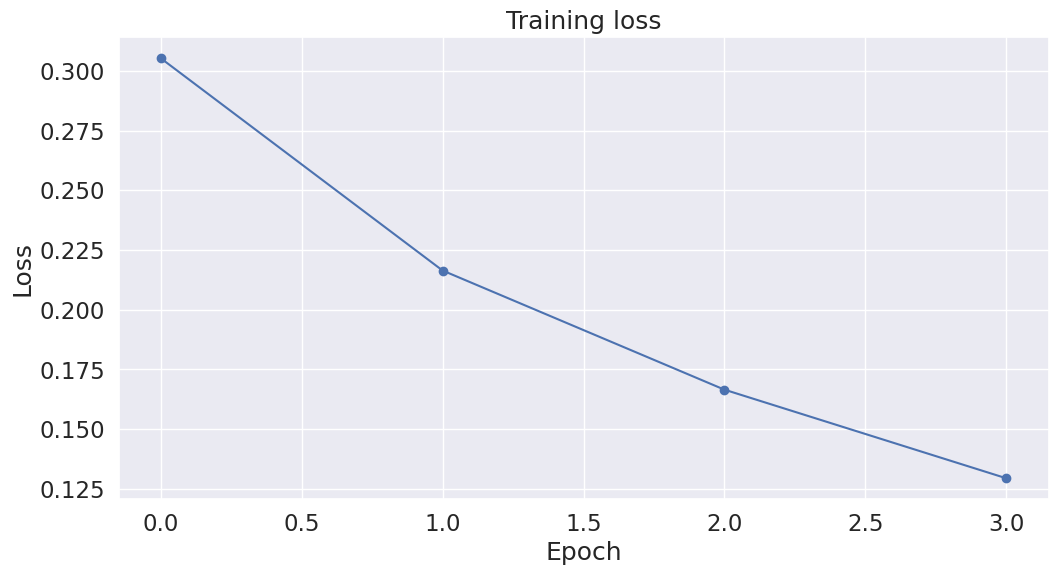

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# On test set

In [44]:
test_inputs, test_masks = bert_encode(tst_sentences,MAX_LEN)

# Convert to tensors.
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)

# Set the batch size.
batch_size = 32

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [45]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 2,478 test sentences...
    DONE.


## Matthew's correlation coefficient
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html

In [46]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 3-column ndarray (one column for "0"
  # one for "1" and one for "2"). Pick the label with the highest value and turn this
  # in to a list of 0s, 1s, 2s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

In [47]:
# Combine the predictions for each batch into a single list of 0s,1s, 2s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.745


## confusion matrix

In [48]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.48      0.41      0.44       155
           1       0.94      0.95      0.94      1893
           2       0.89      0.90      0.89       430

    accuracy                           0.90      2478
   macro avg       0.77      0.75      0.76      2478
weighted avg       0.90      0.90      0.90      2478

